setting up a YOLO model to be able to make bounding boxes around images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cs231data/
import pandas as pd
!pip install torch torchvision torchsummary utils optuna

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1dIpuDwWC8lN1XmawC1FhwT10nB6Cqvge/cs231data
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
import os

directory = "/content/drive/My Drive/cs231data/"

# Recursively list all files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/cs231data/data/false/3050013.jpg
/content/drive/My Drive/cs231data/data/false/3087814.jpg
/content/drive/My Drive/cs231data/data/false/3042519.jpg
/content/drive/My Drive/cs231data/data/false/3045715.jpg
/content/drive/My Drive/cs231data/data/false/3017015.jpg
/content/drive/My Drive/cs231data/data/false/3043899.jpg
/content/drive/My Drive/cs231data/data/false/3060955.jpg
/content/drive/My Drive/cs231data/data/false/3039159.jpg
/content/drive/My Drive/cs231data/data/false/3044786.jpg
/content/drive/My Drive/cs231data/data/false/3077746.jpg
/content/drive/My Drive/cs231data/data/false/3030908.jpg
/content/drive/My Drive/cs231data/data/false/3047258.jpg
/content/drive/My Drive/cs231data/data/false/3093182.jpg
/content/drive/My Drive/cs231data/data/false/3016925.jpg
/content/drive/My Drive/cs231data/data/false/3026125.jpg
/content/drive/My Drive/cs231data/data/false/3073772.jpg
/content/drive/My Drive/cs231data/dat

# YOLO V5

## Clone YOLO repo

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git "/content/drive/My Drive/cs231data/yolov5dyno"
# Change the current directory to the yolov5 folder
%cd /content/drive/My Drive/cs231data/yolov5dyno

# Install the required dependencies
!pip install -r requirements.txt



fatal: destination path '/content/drive/My Drive/cs231data/yolov5dyno' already exists and is not an empty directory.
/content/drive/My Drive/cs231data/yolov5dyno
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Make YOLO friendly boudning box file

In [ ]:
import pandas as pd
import os
from tqdm import tqdm


bbox_df = pd.read_csv('/content/drive/My Drive/cs231data/data_zoomed_out/bounding_boxes.txt', delimiter=' ',
                      header=None, names=['image_name', 'x_center', 'y_center', 'width', 'height'])

bbox_df[['x_center', 'width']] /= 512
bbox_df[['y_center', 'height']] /= 512

# Write to YOLO-format annotation files
os.makedirs('/content/drive/My Drive/cs231data/data_zoomed_out/labels', exist_ok=True)

for idx, row in tqdm(bbox_df.iterrows(), total=bbox_df.shape[0]):
    image_name = row['image_name']
    image_name_without_ext = os.path.splitext(image_name)[0]  # remove the extension
    file_path = f'/content/drive/My Drive/cs231data/data_zoomed_out/labels/{image_name_without_ext}.txt'

    bbox = (row['x_center'], row['y_center'], row['width'], row['height'])

    # Read existing entries in the file
    existing_bboxes = set()
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                _, x, y, w, h = map(float, line.strip().split())
                existing_bboxes.add((x, y, w, h))

    # Write the bbox to the file if it's not already there
    if bbox not in existing_bboxes:
        with open(file_path, 'a') as f:  # Open the file in append mode
            f.write(f"0 {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")


FileNotFoundError: ignored

## Visualize boudning boxes to make sure correct implementation

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

# Choose the first few images to display
n_images = 5

# Path to images and labels
image_dir = '/content/drive/My Drive/cs231data/data_zoomed_out/true/'
label_dir = '/content/drive/My Drive/cs231data/data_zoomed_out/labels/'

# Get list of images
image_files = bbox_df['image_name'].unique()[:n_images]

# For each image
for image_file in image_files:
    # Load image
    img = cv2.imread(os.path.join(image_dir, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load corresponding label
    with open(os.path.join(label_dir, f"{os.path.splitext(image_file)[0]}.txt"), 'r') as f:
        boxes = f.readlines()

    # Create plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # For each box
    for box in boxes:
        # Parse data
        _, x_center, y_center, width, height = map(float, box.strip().split())

        # Denormalize coordinates
        x_center *= img.shape[1]
        y_center *= img.shape[0]
        width *= img.shape[1]
        height *= img.shape[0]

        # Convert to matplotlib format
        x_min = x_center - width / 2
        y_min = y_center - height / 2

        # Create a Rectangle patch and add it to the plot
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show figure
    plt.show()


## Create new directory and copy files into it (YOLO wants files in a specific structure)

In [ ]:
import os
import shutil
from tqdm import tqdm

# Define the directories
source_image_true_dir = '/content/drive/My Drive/cs231data/data_zoomed_out/true'
source_image_false_dir = '/content/drive/My Drive/cs231data/data_zoomed_out/false'
source_label_dir = '/content/drive/My Drive/cs231data/data_zoomed_out/labels'
target_dir = '/content/drive/My Drive/cs231data/yolov5dyno/data/yolo_data'

false_to_true_ratio = 0.5  # ratio of false images to true images

# Delete the yolo_data folder if it exists
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

# Create the target directories
os.makedirs(os.path.join(target_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'valid', 'images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'valid', 'labels'), exist_ok=True)

# Get the list of image files
image_true_files = sorted(os.listdir(source_image_true_dir))
image_false_files = sorted(os.listdir(source_image_false_dir))

num_images_with_labels = 0
num_false_images_copied = 0

# Process and copy images from the 'true' and 'false' directories to the new directories
for image_file in tqdm(image_true_files, total=len(image_true_files), desc="Processing images"):
    try:
        image_name = os.path.splitext(image_file)[0]
        label_file = image_name + '.txt'
        image_true_path = os.path.join(source_image_true_dir, image_file)
        label_path = os.path.join(source_label_dir, label_file)

        if os.path.exists(label_path):
            num_images_with_labels += 1
            if num_images_with_labels % 5 == 0:
                target_image_dir = os.path.join(target_dir, 'valid', 'images')
                target_label_dir = os.path.join(target_dir, 'valid', 'labels')
            else:
                target_image_dir = os.path.join(target_dir, 'train', 'images')
                target_label_dir = os.path.join(target_dir, 'train', 'labels')

            # Copy 'true' image and corresponding label
            target_image_true_path = os.path.join(target_image_dir, image_file)
            shutil.copy2(image_true_path, target_image_true_path)
            target_label_path = os.path.join(target_label_dir, label_file)
            shutil.copy2(label_path, target_label_path)

            # Copy 'false' image if ratio condition is met
            if num_false_images_copied < int(num_images_with_labels * false_to_true_ratio) and image_false_files:
                image_false_file = image_false_files.pop(0)  # pop the first false image from the list
                image_false_path = os.path.join(source_image_false_dir, image_false_file)
                target_image_false_path = os.path.join(target_image_dir, image_false_file)
                shutil.copy2(image_false_path, target_image_false_path)
                num_false_images_copied += 1

    except Exception as e:
        print(f"Error processing image {image_file}. Error: {str(e)}")

print(f"Number of images with corresponding labels: {num_images_with_labels}")
print(f"Number of false images copied: {num_false_images_copied}")
print("Completed copying files.")


Processing false images: 100%|██████████| 19738/19738 [05:34<00:00, 58.92it/s]

Number of images with corresponding labels: 22999
Completed copying files.


## (may be able to skip) Copy the training and validation images and labels into the YOLOv5 directory

In [ ]:
!cp -r /content/drive/My\ Drive/cs231data/yolov5/data/yolo_data/train/ ./data/
!cp -r /content/drive/My\ Drive/cs231data/yolov5/data/yolo_data/valid/ ./data/

## Modify the yaml config file and the training script

# Train the YOLO net


## check size of input images

In [ ]:
import os
from PIL import Image

# Directory path containing the images
image_dir = '/content/drive/My Drive/cs231data/yolov5/data/yolo_data/train/images'

# Get the list of image file names in the directory
image_files = [filename for filename in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, filename))]

# Iterate through the first 10 image files
for i, image_file in enumerate(image_files[:1]):
    # Image path
    image_path = os.path.join(image_dir, image_file)

    # Load the image
    img = Image.open(image_path)

    # Get the height and width of the image
    width, height = img.size

    # Print the image path, height, and width
    print(f'Image {i + 1}: {image_path}')
    print(f'   Height: {height}')
    print(f'   Width: {width}')


Image 1: /content/drive/My Drive/cs231data/yolov5/data/yolo_data/train/images/3036839.jpg
   Height: 512
   Width: 512


##Log:
###Initial attempts with:
!python train.py --img 512 --batch 16 --epochs 2 --data yolo_data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name wind_turbine_model

No bounding boxes created, even on test images
After 2 epochs
box_loss 0.08011    obj_loss 0.023
After 10 epochs
box_loss 0.05693    obj_loss 0.01868   

detects about 50% of wind turbines in images at a confidence threshold of 0.1
most are a confidence of 0.1-0.16
however, detects some twice and misses others that are very clearly turbines

**Bounding boxes generated by grouding dyno**
After 2 epochs
box_loss 0.078    obj_loss 0.02282   
After 10 epochs
box_loss 0.056    obj_loss 0.018   

## Parameter tuning

In [ ]:
!python train.py --img 512 --batch 16 --epochs 1 --data yolo_data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name wind_turbine_model


train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=yolo_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=wind_turbine_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-177-g89c3040 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0,

In [ ]:
import random
import os
import yaml
import subprocess
import numpy as np

# List of hyperparameters to tune
learning_rates = [10**(-x) for x in np.random.uniform(3, 1, size=5)]
batch_sizes = [8, 16, 32]

# Best model parameters
best_mAP = -1
best_params = None

# Base command for training
base_command = "!python train.py --img 512 --batch {batch_size} --epochs {epochs} --data yolo_data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name wind_turbine_model"

# Loop over the hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:

        # Update learning rate in hyp.scratch.yaml file
        with open("hyp.scratch-low.yaml") as f:
            hyp_config = yaml.load(f, Loader=yaml.FullLoader)
        hyp_config["lr0"] = lr
        with open("hyp.scratch-low.yaml", "w") as f:
            yaml.dump(hyp_config, f)

        # Form the training command
        command = base_command.format(batch_size=batch_size, epochs=3)

        print(f"Starting training with - lr: {lr}, batch size: {batch_size}, epochs: 3")

        # Run the command (note: this is a placeholder, replace with actual code to run the command)
        #os.system(command)
        subprocess.call(command, shell=True)

        # Get the mAP of the model (replace this with actual method to get mAP)
        print("Assume that mAP is calculated here and its value is set to mAP variable.")
        mAP = 0.0

        # Update best model if current model is better
        if mAP > best_mAP:
            best_mAP = mAP
            best_params = (lr, batch_size)

# Train the best model for more epochs
if best_params is not None:
    lr, batch_size = best_params

    # Update learning rate in hyp.scratch.yaml file
    with open("hyp.scratch.yaml") as f:
        hyp_config = yaml.load(f, Loader=yaml.FullLoader)
    hyp_config["lr0"] = lr
    with open("hyp.scratch.yaml", "w") as f:
        yaml.dump(hyp_config, f)

    # Form the training command
    command = base_command.format(batch_size=batch_size, epochs=20)

    print(f"Starting training with best parameters - lr: {lr}, batch size: {batch_size}, epochs: 20")

    # Run the command (note: this is a placeholder, replace with actual code to run the command)
    #os.system(command)
    subprocess.call(command, shell=True)


FileNotFoundError: ignored

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-6-7 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


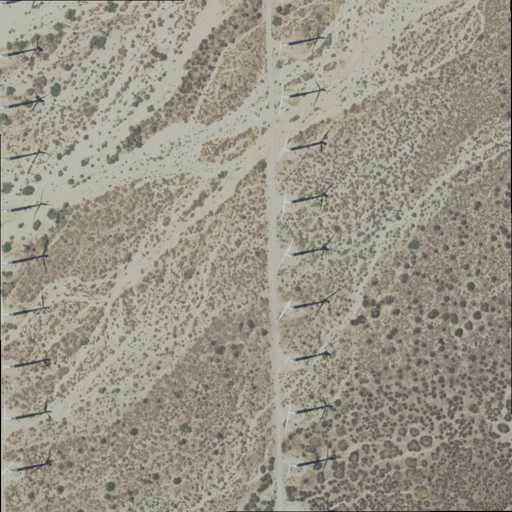

Saved 1 image to runs/detect/exp181


Bounding Box Coordinates: []


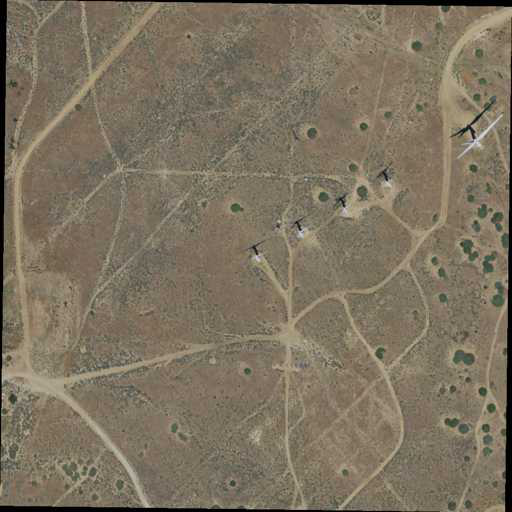

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp182


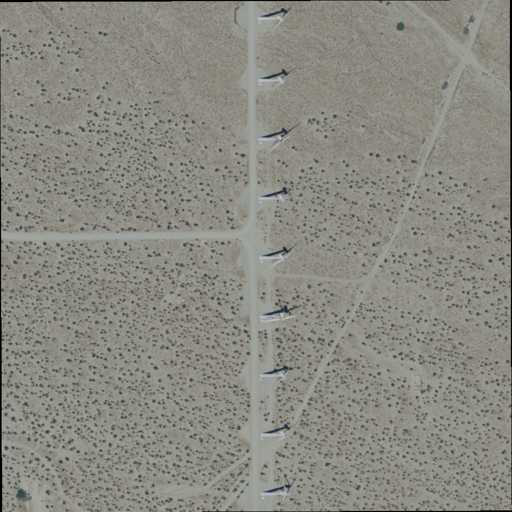

Saved 1 image to runs/detect/exp183


Bounding Box Coordinates: []


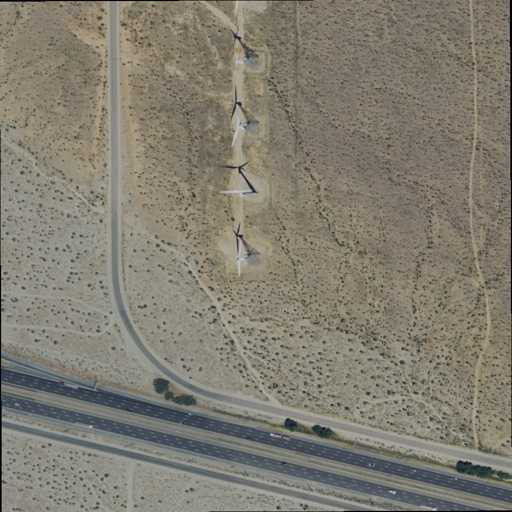

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp184


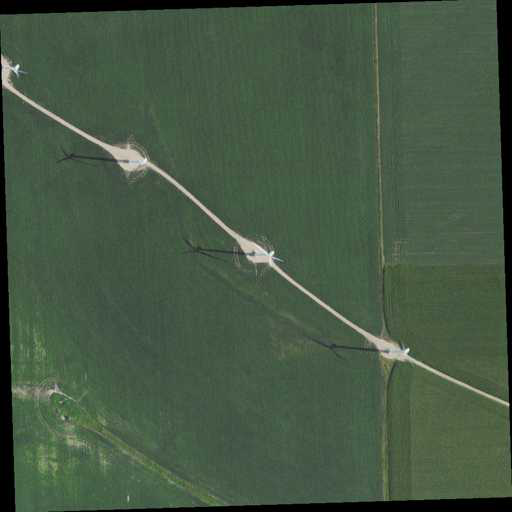

Saved 1 image to runs/detect/exp185


Bounding Box Coordinates: []


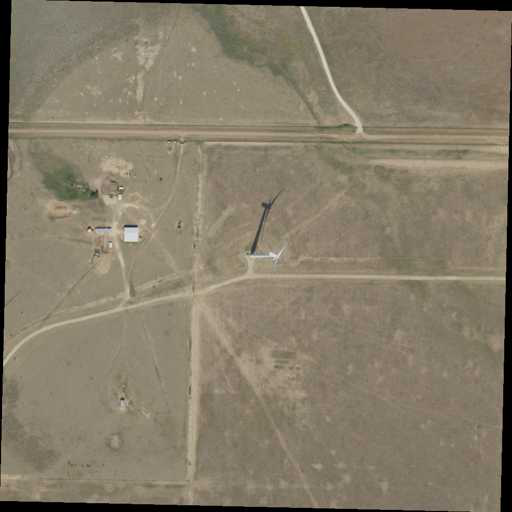

Saved 1 image to runs/detect/exp186


Bounding Box Coordinates: []


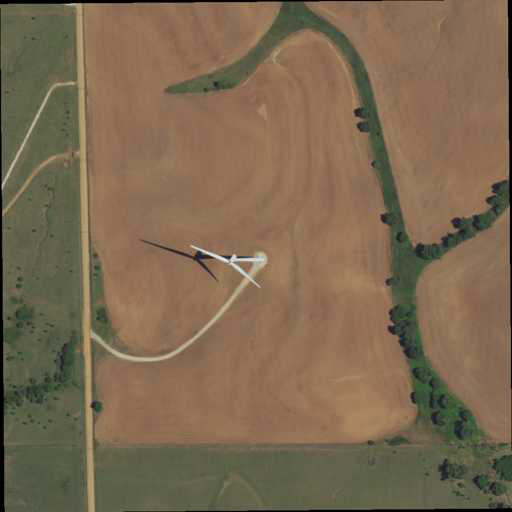

Saved 1 image to runs/detect/exp187


Bounding Box Coordinates: []


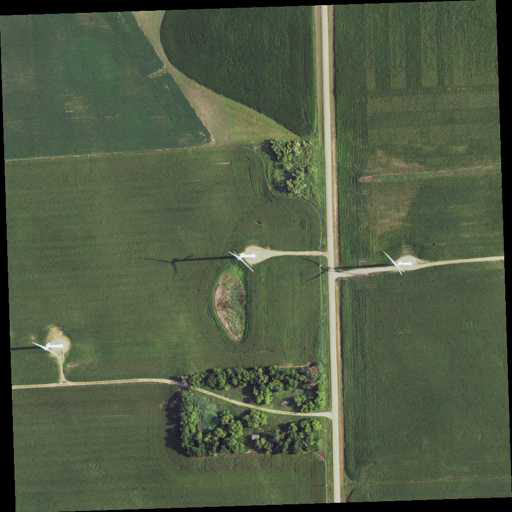

Saved 1 image to runs/detect/exp188


Bounding Box Coordinates: []


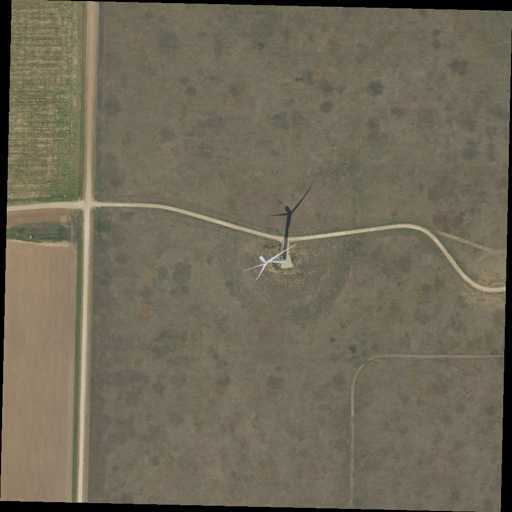

Saved 1 image to runs/detect/exp189


Bounding Box Coordinates: []


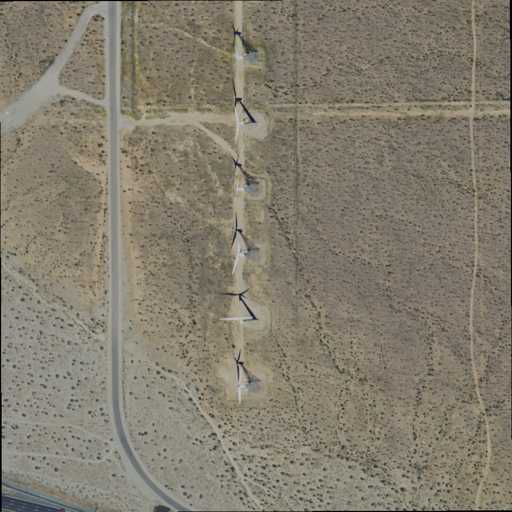

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp190


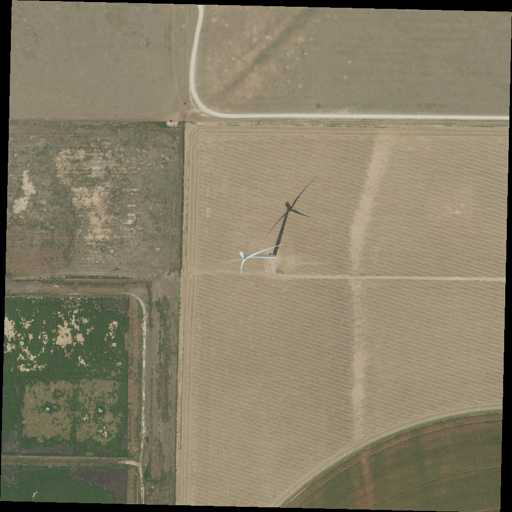

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp191


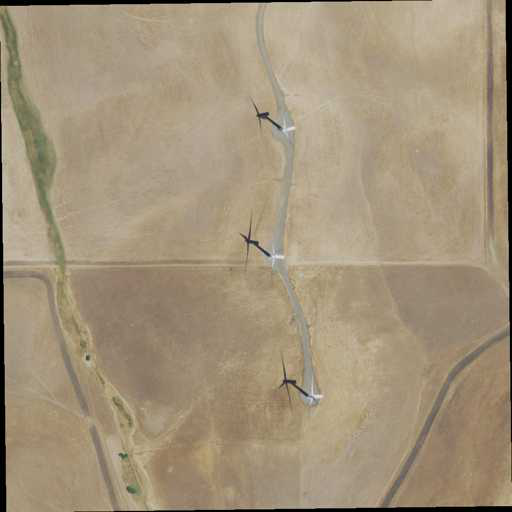

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp192


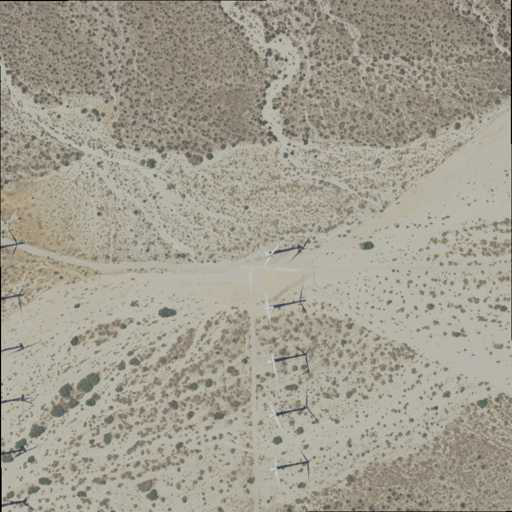

Saved 1 image to runs/detect/exp193


Bounding Box Coordinates: []


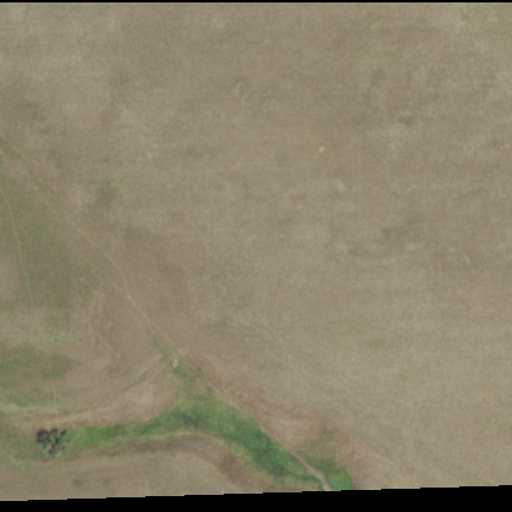

Saved 1 image to runs/detect/exp194


Bounding Box Coordinates: []


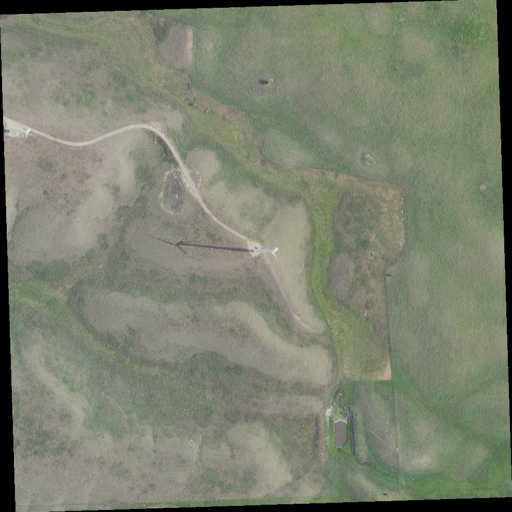

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp195


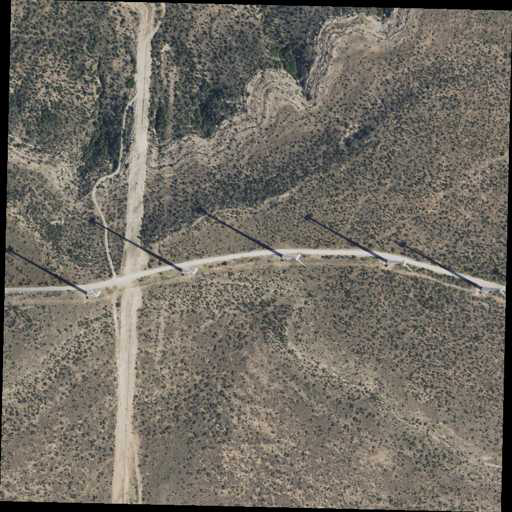

Saved 1 image to runs/detect/exp196


Bounding Box Coordinates: []


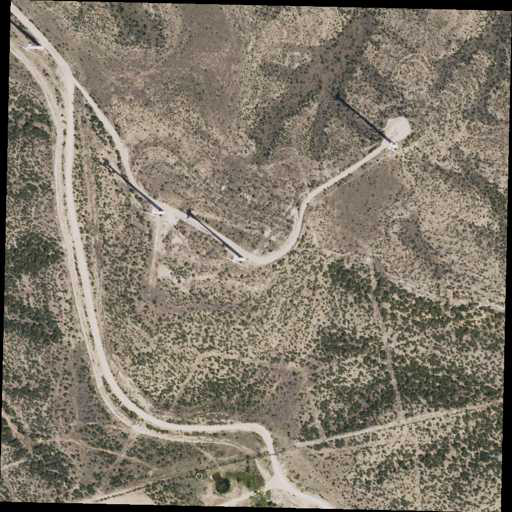

Saved 1 image to runs/detect/exp197


Bounding Box Coordinates: []


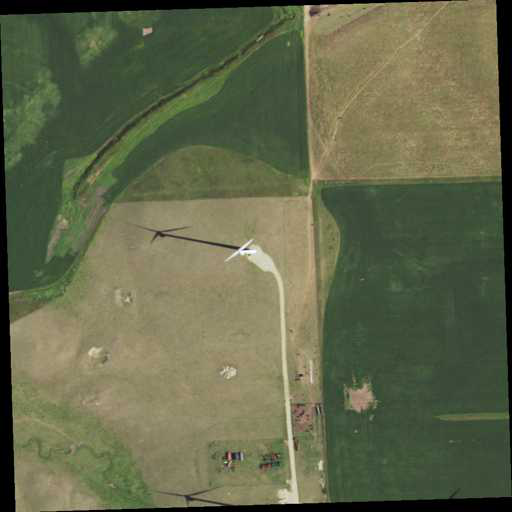

Saved 1 image to runs/detect/exp198


Bounding Box Coordinates: []


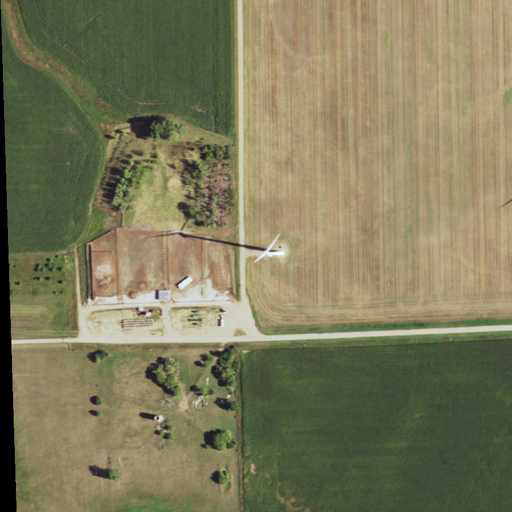

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp199


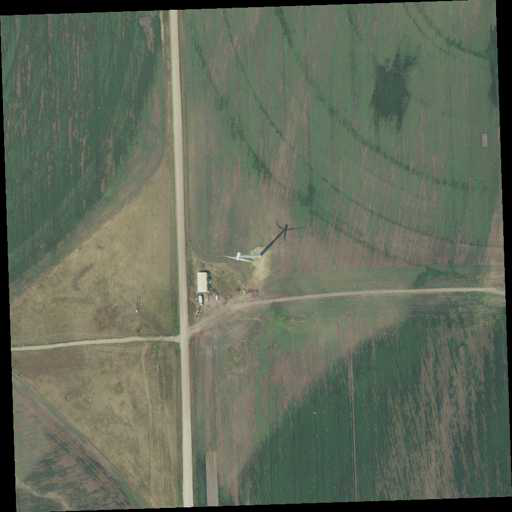

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp200


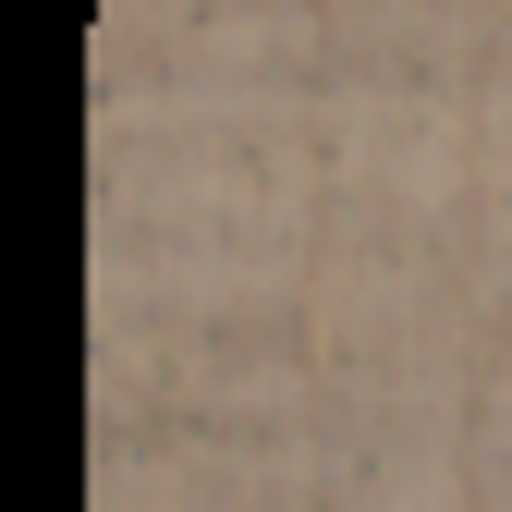

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp201


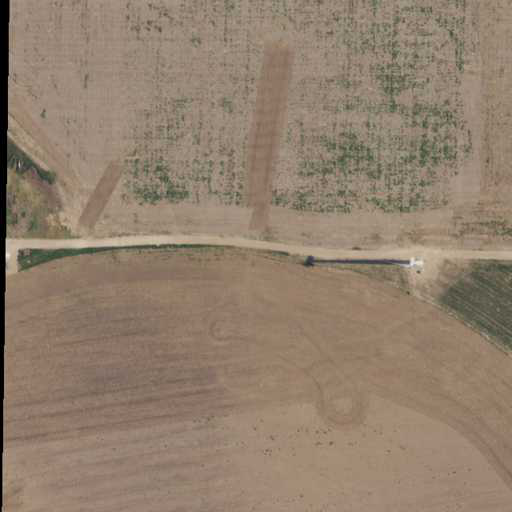

Saved 1 image to runs/detect/exp202


Bounding Box Coordinates: []


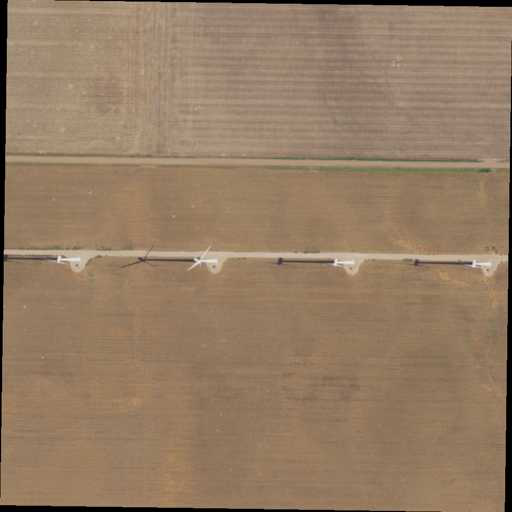

Saved 1 image to runs/detect/exp203


Bounding Box Coordinates: []


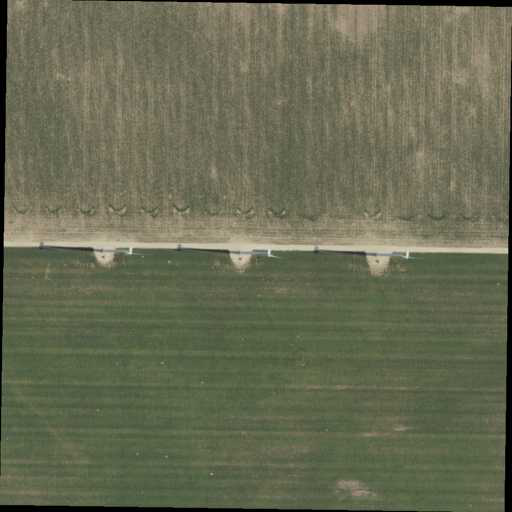

Saved 1 image to runs/detect/exp204


Bounding Box Coordinates: []


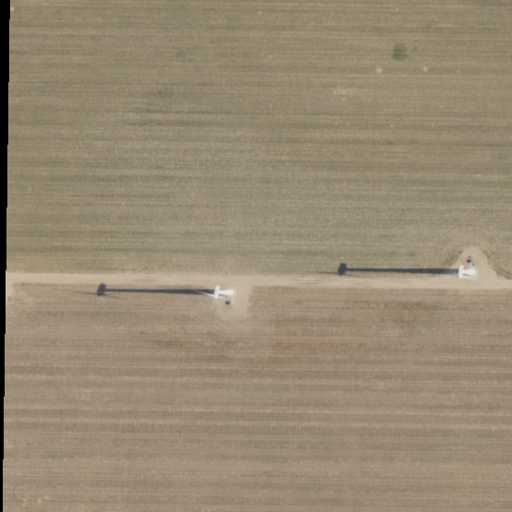

Saved 1 image to runs/detect/exp205


Bounding Box Coordinates: []


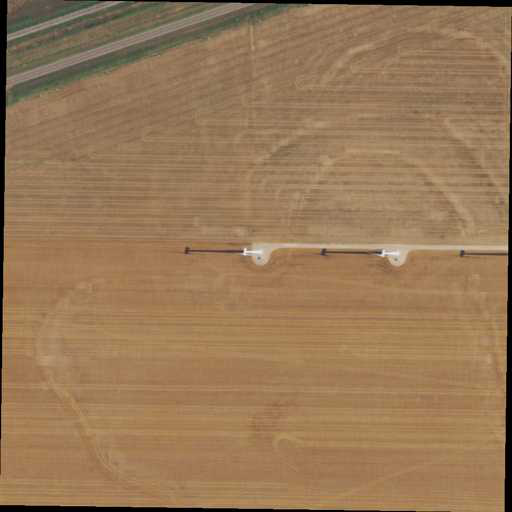

Saved 1 image to runs/detect/exp206


Bounding Box Coordinates: []


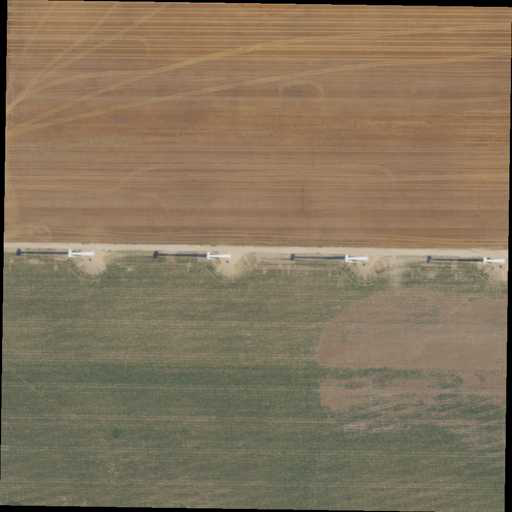

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp207


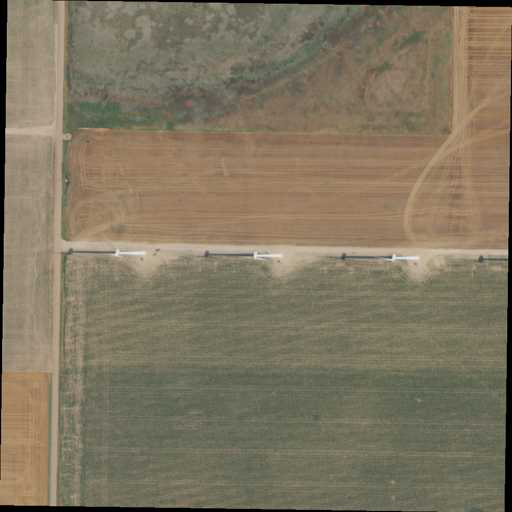

Bounding Box Coordinates: []


Saved 1 image to runs/detect/exp208


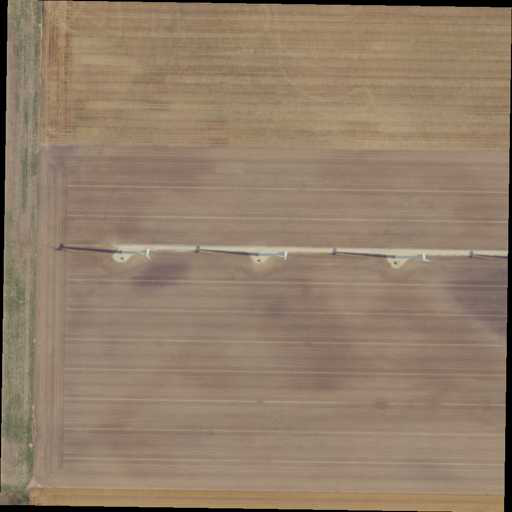

Saved 1 image to runs/detect/exp209


Bounding Box Coordinates: []


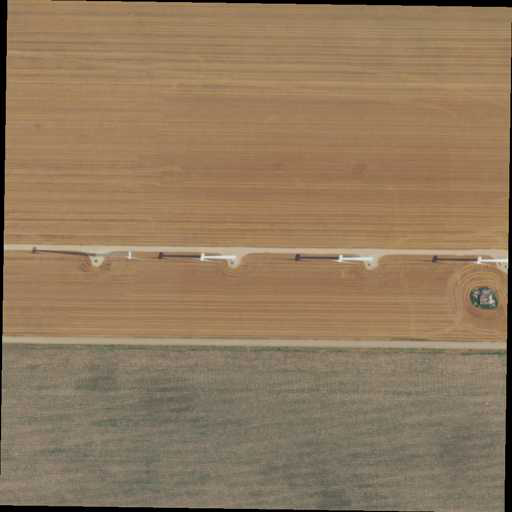

Saved 1 image to runs/detect/exp210


Bounding Box Coordinates: []


In [ ]:
import os
import torch
from PIL import Image

# Specify the paths and configurations
model_weights = 'runs/train/wind_turbine_model4/weights/best.pt'
model_config = 'models/yolov5s.yaml'
data_config = 'yolo_data.yaml'
train_image_dir = '/content/drive/My Drive/cs231data/yolov5dyno/data/yolo_data/train/images'

# Load the trained model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_weights, force_reload=True)

# Lower the confidence threshold
model.conf = 0.05

# Set the model's configuration
model.cfg = model_config

# List all image files in the train folder
image_files = [os.path.join(train_image_dir, file) for file in os.listdir(train_image_dir) if file.endswith('.jpg')]

# Process and visualize the first 3 images
for image_path in image_files[:30]:
    # Load the image
    img = Image.open(image_path)

    # Perform inference
    results = model(img)

    # Visualize the results with bounding boxes
    results.show()

    # Extract the bounding box coordinates
    boxes = results.xyxy[0][:, :4].cpu().numpy()

    # Print the bounding box coordinates
    print(f'Bounding Box Coordinates: {boxes}')

    # Optionally, save the visualized image with bounding boxes
    output_path = image_path.replace('.jpg', '_output.jpg')
    results.save(output_path)
